In [2]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from cliffs_delta import cliffs_delta

import sys
sys.path.insert(1, '../../')
from utils import cohen_d

import sys

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(1)
os.environ["MKL_NUM_THREADS"] = str(1)
os.environ["OPENBLAS_NUM_THREADS"] = str(1)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(1)
os.environ["NUMEXPR_NUM_THREADS"] = str(1)

Load interaction results:

In [82]:
res_all = pd.read_csv(os.path.join(data_path, 'processed', 'joint_ols_perm_interactions.csv'), 
                     index_col = 0)

Filter for significant interactions by permutation test:

In [83]:
alpha = 0.2
res_all = res_all[res_all.bh_fdr_perm <= alpha]

print('There are {} significant interactions'.format(res_all.shape[0]))

There are 38 significant interactions


Check for concordance between the OLS and permutation approach:

In [84]:
stats.spearmanr(res_all.coef_perm, 
                res_all.coef_OLS)

SignificanceResult(statistic=-0.7800634642739905, pvalue=7.775968334894858e-09)

Identify which features occur in the most interactions:

In [85]:
feature_counts = pd.Series(res_all.feature_1.tolist() + res_all.feature_2.tolist()).value_counts()
feature_counts

SLX4 (84464)       6
ZC3H10 (84872)     6
CELSR3 (1951)      5
SP1 (6667)         4
PA2G4 (5036)       4
AXIN1 (8312)       4
ARRB2 (409)        3
SREBF2 (6721)      3
FYCO1 (79443)      3
WDR36 (134430)     2
TBC1D5 (9779)      2
SLC22A13 (9390)    2
SELENOI (85465)    2
HTT (3064)         2
KBTBD8 (84541)     2
PRKAR2A (5576)     2
PGGT1B (5229)      2
PLXNA3 (55558)     1
STAT5B (6777)      1
FOXL2 (668)        1
EPN1 (29924)       1
ZNHIT2 (741)       1
APC (324)          1
LEF1 (51176)       1
SLC12A6 (9990)     1
BRCA1 (672)        1
GPHN (10243)       1
DHX30 (22907)      1
TGFBRAP1 (9392)    1
RTL6 (84247)       1
TULP4 (56995)      1
SIN3A (25942)      1
HIP1 (3092)        1
USP8 (9101)        1
RDH11 (51109)      1
DYNC1H1 (1778)     1
MAPK3 (5595)       1
REL (5966)         1
MLST8 (64223)      1
Name: count, dtype: int64

In [86]:
feature_counts.shape

(39,)

In [87]:
feature_counts[feature_counts > 1].shape

(17,)

In [24]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)
feature_rank_map = dict(zip(model_coefs.index, range(model_coefs.shape[0] + 1)))
print(np.mean(feature_counts.index.map(feature_rank_map)))
feature_counts.index.map(feature_rank_map)

10108.28205128205


Index([ 4988, 11608,  6234,  7582,  3983, 14440, 10125, 15968,  5132, 17276,
        5020, 16550, 14972,  3775, 11782, 17074, 14451,  1092, 12420, 17629,
        4942,  6222,  7077,  1352,  7367,  6394, 11193,  6108, 16352, 12833,
       16720, 11009,  6925, 13052, 17609, 14681, 11238,  5375,  5673],
      dtype='int64')

In [90]:
feature_counts

SLX4 (84464)       6
ZC3H10 (84872)     6
CELSR3 (1951)      5
SP1 (6667)         4
PA2G4 (5036)       4
AXIN1 (8312)       4
ARRB2 (409)        3
SREBF2 (6721)      3
FYCO1 (79443)      3
WDR36 (134430)     2
TBC1D5 (9779)      2
SLC22A13 (9390)    2
SELENOI (85465)    2
HTT (3064)         2
KBTBD8 (84541)     2
PRKAR2A (5576)     2
PGGT1B (5229)      2
PLXNA3 (55558)     1
STAT5B (6777)      1
FOXL2 (668)        1
EPN1 (29924)       1
ZNHIT2 (741)       1
APC (324)          1
LEF1 (51176)       1
SLC12A6 (9990)     1
BRCA1 (672)        1
GPHN (10243)       1
DHX30 (22907)      1
TGFBRAP1 (9392)    1
RTL6 (84247)       1
TULP4 (56995)      1
SIN3A (25942)      1
HIP1 (3092)        1
USP8 (9101)        1
RDH11 (51109)      1
DYNC1H1 (1778)     1
MAPK3 (5595)       1
REL (5966)         1
MLST8 (64223)      1
Name: count, dtype: int64

Since we used feature sets, where the idea was to focus on modules of interactions, let's focus on these features that have multiple interactions:

In [25]:
multiple_interactions = feature_counts[feature_counts >= 2]
multiple_interactions

SLX4 (84464)       6
ZC3H10 (84872)     6
CELSR3 (1951)      5
SP1 (6667)         4
PA2G4 (5036)       4
AXIN1 (8312)       4
ARRB2 (409)        3
SREBF2 (6721)      3
FYCO1 (79443)      3
WDR36 (134430)     2
TBC1D5 (9779)      2
SLC22A13 (9390)    2
SELENOI (85465)    2
HTT (3064)         2
KBTBD8 (84541)     2
PRKAR2A (5576)     2
PGGT1B (5229)      2
Name: count, dtype: int64

In [26]:
multiple_interactions.shape

(17,)

In [12]:
# res_multiple = res_all[(res_all.feature_1.isin(multiple_interactions.index)) | (res_all.feature_1.isin(multiple_interactions.index))]
# res_multiple.shape

In [27]:
# tuple_list = list(zip(res_multiple['feature_1'], res_multiple['feature_2']))
tuple_list = list(zip(res_all['feature_1'], res_all['feature_2']))
tuple_list = [i[0] + ' & ' + i[1] for i in tuple_list]
print(*tuple_list, sep = ', ')

# tuple_list = list(zip(res_multiple['feature_1'], res_multiple['feature_2']))
# tuple_list = [i[0] + ' & ' + i[1] for i in tuple_list]
# print(*tuple_list, sep = ', ')


WDR36 (134430) & FYCO1 (79443), STAT5B (6777) & SP1 (6667), SREBF2 (6721) & ZC3H10 (84872), TBC1D5 (9779) & SLC22A13 (9390), PLXNA3 (55558) & TBC1D5 (9779), SLX4 (84464) & PRKAR2A (5576), ARRB2 (409) & SIN3A (25942), SLX4 (84464) & CELSR3 (1951), CELSR3 (1951) & SELENOI (85465), SLX4 (84464) & PGGT1B (5229), APC (324) & AXIN1 (8312), SREBF2 (6721) & FYCO1 (79443), ZNHIT2 (741) & PRKAR2A (5576), SP1 (6667) & ARRB2 (409), EPN1 (29924) & HIP1 (3092), ZC3H10 (84872) & CELSR3 (1951), PA2G4 (5036) & SP1 (6667), FOXL2 (668) & USP8 (9101), KBTBD8 (84541) & SREBF2 (6721), DHX30 (22907) & SLX4 (84464), TGFBRAP1 (9392) & SP1 (6667), ZC3H10 (84872) & RDH11 (51109), CELSR3 (1951) & WDR36 (134430), ZC3H10 (84872) & DYNC1H1 (1778), GPHN (10243) & AXIN1 (8312), ZC3H10 (84872) & PGGT1B (5229), BRCA1 (672) & AXIN1 (8312), SLC12A6 (9990) & SELENOI (85465), LEF1 (51176) & HTT (3064), PA2G4 (5036) & MAPK3 (5595), HTT (3064) & ARRB2 (409), PA2G4 (5036) & REL (5966), PA2G4 (5036) & AXIN1 (8312), RTL6 (84247)

# Biological Interpretation

https://chatgpt.com/share/67fea334-0730-800b-8080-d5f8ac8f5e72 <-- DEPR

# Topology Based Interpretation

In [29]:
from typing import Union, List
import networkx as nx

def flatten_list(list1) -> list:
    return [item for sublist in list1 for item in sublist]

def drop_duplicate_interactions(sn_ppis: pd.DataFrame, 
                             source_label: str = 'source_genesymbol',
                             target_label: str = 'target_genesymbol',
                             stimulation_label: str = 'consensus_stimulation',
                             inhibition_label: str = 'consensus_inhibition'):
    """Systematically aggregate any duplicate interactions between the source and target node. 

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network, output of `scLEMBAS.parse_network.load_network`
    source_label : str
        the column label for source nodes in the graph, by default 'source_genesymbol'
    target_label : str
        the column label for the target node in the graph, by default 'target_genesymbol'
    stimulation_label : str, optional
        column name of stimulating interactions, see `sn_ppis`, by default 'consensus_stimulation'
    inhibition_label : str, optional
        column name of inhibitory interactions, see `sn_ppis`, by default 'consensus_inhibition'

    Returns
    -------
    sn_ppis : pd.DataFrame
        a copy of the input interaction network with duplicates aggregated
    """

    sn_ppis = sn_ppis.copy()
    duplicated_interactions = sn_ppis[sn_ppis.duplicated(subset = [source_label, target_label], keep='first')].drop_duplicates(subset = [source_label, target_label])
    unique_vals = pd.DataFrame(columns = sn_ppis.columns)
    drop_indeces = []
    for idx in tqdm(duplicated_interactions.index):
        source = duplicated_interactions.loc[idx, source_label]
        target = duplicated_interactions.loc[idx, target_label]

        dup_int = sn_ppis[(sn_ppis[source_label] == source) & (sn_ppis[target_label] == target)].copy()
        drop_indeces += dup_int.index.tolist()
        dup_int.reset_index(inplace = True, drop = True)

        if (dup_int[[source_label, target_label, stimulation_label, inhibition_label, 'n_references', 'curation_effort', 'references' ]].nunique() == 1).all():
            dup_int = pd.DataFrame(dup_int.iloc[0, :]).T
        else:
            # filter by n_references
            dup_int = dup_int[dup_int.n_references == dup_int.n_references.max()]
            # filter by curation effort
            if dup_int.shape[0] > 1:
                dup_int = dup_int[dup_int.curation_effort == dup_int.curation_effort.max()]
            # merge remaining
            if dup_int.shape[0] > 1:
                if dup_int[stimulation_label].nunique() > 1:
                    dup_int[stimulation_label] = False
                if dup_int[inhibition_label].nunique() > 1:
                    dup_int[stimulation_label] = False
                references = sorted(set(flatten_list([ref.split(';') if not (type(ref) == float and np.isnan(ref)) else [ref] for ref in dup_int.references.tolist()])))
                references = [ref for ref in references if not (type(ref) == float and np.isnan(ref))]
                n_references = len(references)
                dup_int = dup_int.iloc[0, :]
                dup_int['n_references'] = n_references
                dup_int['references'] = ';'.join(references) if len(references) > 0 else np.nan
                dup_int = pd.DataFrame(dup_int).T
        if dup_int.shape[0] != 1:
            raise ValueError('There are still duplicated interactions')

        unique_vals = pd.concat([unique_vals, dup_int], axis = 0)

    sn_ppis.drop(index = drop_indeces, inplace = True)
    sn_ppis = pd.concat([sn_ppis, unique_vals], axis = 0)
    sn_ppis.reset_index(inplace = True, drop = True)
    if sn_ppis.duplicated(subset = [source_label, target_label]).any():
        raise ValueError('Interaction DB still has duplicates')

    return sn_ppis

def correct_moa(sn_ppis: pd.DataFrame,
                stimulation_label: str = 'consensus_stimulation',
                inhibition_label: str = 'consensus_inhibition'):
    """In the case where mode of action is True for both stimulating and inhibiting, make this an unknown MOA.

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network, output of `scLEMBAS.parse_network.load_network`
    stimulation_label : str, optional
        column name of stimulating interactions, see `sn_ppis`, by default 'consensus_stimulation'
    inhibition_label : str, optional
        column name of inhibitory interactions, see `sn_ppis`, by default 'consensus_inhibition'

    Returns
    -------
    sn_ppis : pd.DataFrame
        a copy of the input interaction network with duplicates aggregated
    """
    sn_ppis = sn_ppis.copy()
    sn_ppis.loc[sn_ppis[(sn_ppis[stimulation_label] == 1) & (sn_ppis[inhibition_label] == 1)].index, 
    [stimulation_label, inhibition_label]] = [False, False]
    
    return sn_ppis

def extract_network(sn_ppis: pd.DataFrame, 
                              curation_effort_thresh: int = 5, n_references_thresh: int = 3,
                              resources: Union[List, str] = 'all',
                            drop_self: bool = True,
                             source_label: str = 'source_genesymbol',
                             target_label: str = 'target_genesymbol',
                             verbose: bool = True):
    """Various filters on the ppi network.

    Parameters
    ----------
    sn_ppis : pd.DataFrame
        an edge list representing the signaling network
    curation_effort_thresh : int, optional
        threshold of curation effort to retain interaction, by default 5
    n_references_thresh : int, optional
        threshold of number of references to retain interaction, by default 3
    resources : Union[List, str], optional
        resources from which to retain interactions, by default 'all' which won't filter out resources
    drop_self : bool, optional
        get rid of self-interacting nodes, by default True
    source_label : str
        the column label for source nodes in the graph, by default 'source_genesymbol'
    target_label : str
        the column label for the target node in the graph, by default 'target_genesymbol'
    verbose : bool, optional
        print status of network extraction, by default True

    Returns
    -------
    sn_ppis : pd.DataFrame
        an edge list representing the filtered signaling network
    """

    n_int_a = sn_ppis.shape[0]
    
    sn_ppis = sn_ppis[(sn_ppis.n_references >= n_references_thresh) & (sn_ppis.curation_effort >= curation_effort_thresh)]
    if verbose:
        n_int_b = sn_ppis.shape[0]
        print('The thresholds filtered {}  of {} interactions'.format(n_int_a - n_int_b, n_int_a))
    
    if resources and resources != 'all':
        n_sources = sn_ppis.sources.apply(lambda x: len(set(x.split(';')).intersection(resources)))
        sn_ppis = sn_ppis[n_sources > 0]
        if verbose:
            n_int_c = sn_ppis.shape[0]
            print('The resources filtered {}  of {} interactions'.format(n_int_b - n_int_c, n_int_b))

    if drop_self:
        sn_ppis = sn_ppis[sn_ppis[[source_label, target_label]].apply(lambda x: x.nunique() == 2, axis = 1)]

    return sn_ppis

In [30]:
ppi_link = 'https://zenodo.org/records/11477837/files/organism_omnipath_ppi_05_24_24.csv'
organism = 'human'
sn_ppis = pd.read_csv(ppi_link.replace('organism', organism), index_col = 0) 

# some formatting and filtering
sn_ppis['n_references'] = sn_ppis.n_references.fillna(sn_ppis.n_references.min() - 1)
sn_ppis['curation_effort'] = sn_ppis.curation_effort.fillna(sn_ppis.curation_effort.min() - 1)

sn_ppis = drop_duplicate_interactions(sn_ppis)
sn_ppis = correct_moa(sn_ppis)
sn_ppis = extract_network(sn_ppis,
                curation_effort_thresh =  1, 
                n_references_thresh = 0, 
                resources = 'all', 
                drop_self = False)

source_label = 'source_genesymbol'
target_label = 'target_genesymbol'

  0%|                                                   | 0/493 [00:00<?, ?it/s]/tmp/ipykernel_3803008/1927493514.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_vals = pd.concat([unique_vals, dup_int], axis = 0)
100%|█████████████████████████████████████████| 493/493 [00:04<00:00, 98.82it/s]


The thresholds filtered 36590  of 133607 interactions


In [31]:
G = nx.from_pandas_edgelist(sn_ppis, source_label, target_label,
                            create_using = nx.DiGraph() if sn_ppis[sn_ppis.is_directed].shape[0] == sn_ppis.shape[0] else None)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)


In [32]:
interacting_genes = list(set(res_all.feature_1_gene_name.tolist() + res_all.feature_2_gene_name.tolist()))
network_genes = set(sn_ppis.source_genesymbol.tolist() + sn_ppis.target_genesymbol.tolist())

print('The following genes are not present in Omnipath')    
missing_genes = list(set(interacting_genes).difference(network_genes))
feature_counts.index = pd.Series(feature_counts.index).apply(lambda x: x.split(' (')[0]).tolist()

feature_counts.loc[missing_genes]

The following genes are not present in Omnipath


RDH11       1
PGGT1B      2
KBTBD8      2
TULP4       1
SLC22A13    2
CELSR3      5
WDR36       2
ZNHIT2      1
ZC3H10      6
SELENOI     2
RTL6        1
Name: count, dtype: int64

In [33]:
feature_counts = pd.DataFrame(feature_counts)
feature_counts.rename(columns = {'count': 'n_interactions'}, inplace = True)
feature_counts['degree_centrality'] = feature_counts.index.map(degree_centrality)
feature_counts['eigenvector_centrality'] = feature_counts.index.map(eigenvector_centrality)

feature_counts.to_csv(os.path.join(data_path, 'processed', 
                                   'high_confidence_interaction_features.csv'))

feature_counts.to_csv(os.path.join(data_path, 'processed', 
                                   'high_confidence_interaction_features.csv'))

In [18]:
feature_counts = pd.DataFrame(feature_counts)
feature_counts.rename(columns = {'count': 'n_interactions'}, inplace = True)
feature_counts['degree_centrality'] = feature_counts.index.map(degree_centrality)
feature_counts['eigenvector_centrality'] = feature_counts.index.map(eigenvector_centrality)

feature_counts.to_csv(os.path.join(data_path, 'processed', 
                                   'high_confidence_interaction_features.csv'))

feature_counts.to_csv(os.path.join(data_path, 'processed', 
                                   'high_confidence_interaction_features.csv'))

In [80]:
# sns.swarmplot(data = feature_counts, x = 'n_interactions', y = 'eigenvector_centrality')


# n_interactions_to_consider = (feature_counts.n_interactions.value_counts() > 2).loc[lambda x: x].index


# fc_sub = feature_counts[feature_counts.n_interactions.isin(n_interactions_to_consider)]

# stats.spearmanr(feature_counts[feature_counts.eigenvector_centrality.notna()].n_interactions, 
#                 feature_counts[feature_counts.eigenvector_centrality.notna()].eigenvector_centrality)

In [21]:
# mc = feature_counts[feature_counts.n_interactions > 1]
# stats.spearmanr(mc[mc.centrality.notna()].n_interactions, 
#                 mc[mc.centrality.notna()].centrality)

In [38]:
model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'joint_features.csv'), 
                          index_col = 0)
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.set_index('feature_name', inplace = True)
# model_coefs['rank'] = range(model_coefs.shape[0])

model_coefs['interacting'] = False
interacting_features = list(set(res_all.feature_1.tolist() + res_all.feature_2.tolist()))
model_coefs.loc[interacting_features, 'interacting'] = True
model_coefs['degree_centrality'] = model_coefs.gene_name.map(degree_centrality)
model_coefs['eigenvector_centrality'] = model_coefs.gene_name.map(eigenvector_centrality)


# model_coefs = model_coefs[model_coefs.centrality.notna()]


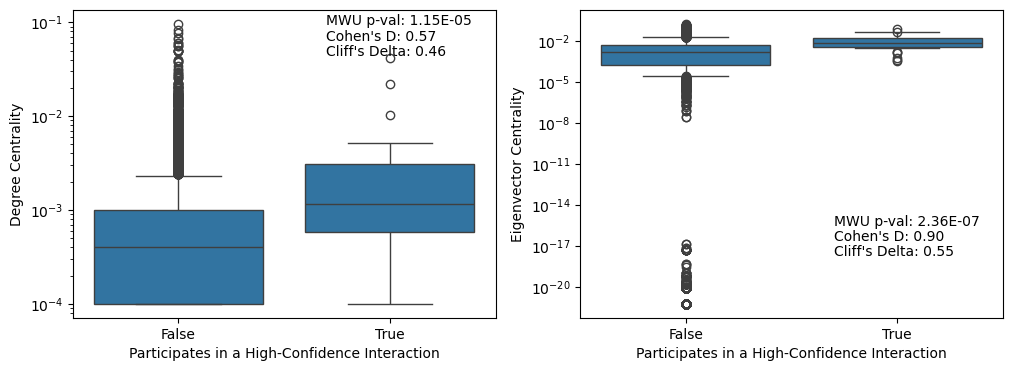

In [39]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))


for i, centrality in enumerate(['degree_centrality', 'eigenvector_centrality']):
    viz_df = model_coefs.copy()
    viz_df = viz_df[viz_df[centrality].notna()]
    
    a = viz_df[viz_df.interacting][centrality]
    b = viz_df[~viz_df.interacting][centrality]
    pval = stats.mannwhitneyu(a, b, alternative = 'greater').pvalue
    ch_d = cohen_d(a, b)
    cl_d = cliffs_delta(a, b)[0]
    
    y = 0.95 if centrality == 'degree_centrality' else 0.3
    y_delta = 0.05
    x = 0.6
    ax[i].annotate('MWU p-val: {:.2E}'.format(pval), xy=(x, y), xycoords='axes fraction')
    ax[i].annotate("Cohen's D: {:.2f}".format(ch_d), xy=(x, y - y_delta), xycoords='axes fraction')
    ax[i].annotate("Cliff's Delta: {:.2f}".format(cl_d), xy=(x, y - (2*y_delta)), xycoords='axes fraction')
    
    
    whis = 1.5 if centrality == 'degree_centrality' else (20, 95)
    sns.boxplot(data = viz_df, x = 'interacting', y = centrality, whis = whis, ax = ax[i])
    ax[i].set_yscale('log')
    ax[i].set_ylabel(' '.join([s[0].upper() + s[1:] for s in centrality.split('_')]))
    
    ax[i].set_xlabel('Participates in a High-Confidence Interaction')
    
plt.savefig(os.path.join(data_path, 'figures', 'interaction_centrality_comparison.png'), 
            dpi=300, 
            bbox_inches="tight")  